Linear Programming
------------------

Let's start by using linear programming on a simple example, taken from Wikipedia:

Suppose that a farmer has a piece of farm land, say $L~\text{km}^2$, to be planted with either wheat or barley or some combination of the two. The farmer has a limited amount of fertilizer, $F$ kilograms, and pesticide, $P$ kilograms. Every square kilometer of wheat requires $F_1$ kilograms of fertilizer and $P_1$ kilograms of pesticide, while every square kilometer of barley requires $F_2$ kilograms of fertilizer and $P_2$ kilograms of pesticide. Let $S_1$ be the selling price of wheat per square kilometer, and $S_2$ be the selling price of barley. If we denote the area of land planted with wheat and barley by $x_1$ and $x_2$ respectively, then profit can be maximized by choosing optimal values for $x_1$ and $x_2.$ This problem can be expressed with the following linear programming problem in the standard form:

$$
\max S_1 x_1 + S_2 x_2
$$
subject to
$$
\begin{align}
x_1 + x_2 &\leq L\\
F_1 x_1 + F_2 x_2 &\leq F\\
P_1 x_1 + P_2 x_2 &\leq P\\
\end{align}
$$

In [9]:
# You may need to `pip install scipy`
import scipy.optimize
import numpy as np

import pylab
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10)
import matplotlib.patches as patches

In [139]:
# Let's find the solution for the following example
S1, S2 = 4.50 / 2, 5.30
L = 10
F = 50
P = 70
F1, F2 = 3, 6
P1, P2 = 9, 4

c = np.array([S1, S2])
A = np.array([[1,1],[F1,F2],[P1,P2]])
b = np.array([L,F,P])

# scipy.optimize.linprog tries to minimize <c, x>, so we negate c.
answer = scipy.optimize.linprog(-c, A, b)

print("Solution assignment:", answer.x)
print("Solution value:", -answer.fun)

Solution assignment: [ 0.          8.33333333]
Solution value: 44.1666666667


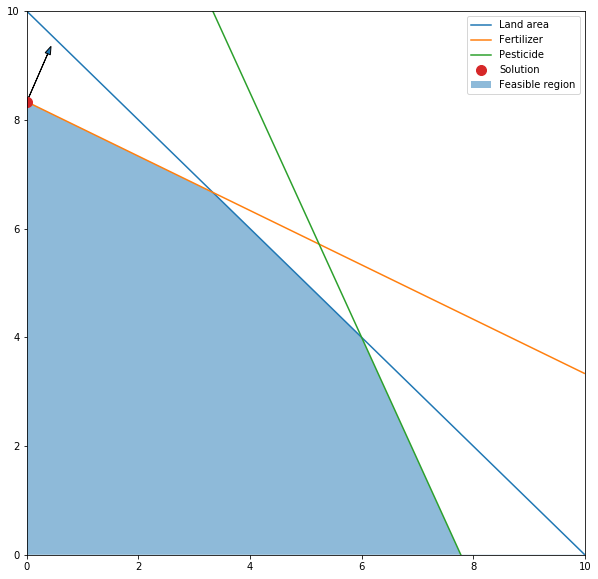

In [140]:
# Let's plot this visually.

x1 = np.arange(0, 10, 0.01)
x1_contribution_to_constraints = A[:,:1].dot(x1.reshape(1,-1))
matching_x2 = (b.reshape(-1,1) - x1_contribution_to_constraints) / A[:,1:]

pylab.plot(x1, matching_x2[0,:], label='Land area')
pylab.plot(x1, matching_x2[1,:], label='Fertilizer')
pylab.plot(x1, matching_x2[2,:], label='Pesticide')
pylab.ylim(0, 10)
pylab.xlim(0, 10)
pylab.fill_between(x1, 0, np.min(matching_x2, axis=0),
                   alpha=0.5, label="Feasible region")
pylab.plot(answer.x[0], answer.x[1], ls='None', marker='o', ms=10, label='Solution')
pylab.arrow(answer.x[0], answer.x[1], S1/6., S2/6., head_width=.1)
pylab.legend()

Question 1:
----------

 (a) What would happen if the price of wheat rose by 25%?  Find the solution assignment, value, and corresponding plot.
 
    In the code above, S1 represents the price of wheat. Increasing S1 by 25% (or multiplying S1 by 1.25) causes the 
      solution assignment, value, and corresponding plot to change to:
      
      Solution assignment: [ 6.  4.]
      Solution value: 54.95
      (Graph shown below)

 (b) Now, suppose the price of wheat collapsed while the price of barley remains stable.  How much would it have to collapse by for the farmer to stop growing any wheat at all?
 
 If the price of wheat falls below half the price of barley, the farmer should stop growing wheat and soley grow barley in order to maximize profit.
 

Question 2:
------------

Write out the dual linear program and solve it.

In [59]:
# Hint: by reusing A, b, c from above this can be a single line of code.
dual_answer = scipy.optimize.linprog(-b, A.transpose(), c)
print("Solution value:", dual_answer.fun)

Solution value: -53.8571428571


Copy of last pset's code
-----------------------

Now let's use linear programming to solve the network flow problem from last time.  Let's start by copying that code.

In [60]:
# You may need to `pip install networkx` and `pip install numpy`
# We'll use NetworkX as in problem set 3 and 5.
import networkx as nx
# https://networkx.github.io/documentation/stable/tutorial.html

import numpy as np

#Visualization tools
import pylab
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10,10)
import matplotlib.patches as patches

In [73]:
def find_path(residual, s, t):
    """Find the shortest s->t path over nonzero edges in residual graph."""
    # Remove zero-weight edges, and use a copy so we don't change the graph
    r = residual.copy()
    r.remove_edges_from([e for e in r.edges if
                         r.edges[e]['c'] == 0])
    # and find the shortest path      
    try:
        return nx.shortest_path(r, s, t)
    except nx.exception.NetworkXNoPath:
        return None

def max_flow(G, s, t):
    """Find the maximum s-t flow in a graph via Ford-Fulkerson.
    
    G.edges[(u,v)]['c'] denotes the capacity of the u->v edge.
    
    Return a dictionary of the flows where
      flow[(u,v)] = flow from u->v in a max flow solution.
    """
    residual = G.copy()
    while True:
        augmenting_path = find_path(residual, s, t)
        if augmenting_path is None:
            break
            
        # Find the capacity along the path
        path_edges = list(zip(augmenting_path[:-1], augmenting_path[1:]))
        path_capacities = [residual.edges[e]['c'] for e in path_edges]
        flow_this_round = min(path_capacities)
        #Subtract from forward edges, add to reverse
        for u,v in path_edges:
            residual.edges[(u,v)]['c'] -= flow_this_round
            if (v,u) not in residual.edges:
                residual.add_edge(v,u, c=0)
            residual.edges[(v,u)]['c'] += flow_this_round

    # Problem 1: Oops! We forgot to actually compute the `flow`
    # dictionary.  Rectify this.
    flow = {}
    for (u,v) in G.edges:
        residual_capacity = residual.edges[(u,v)]['c']
        flow_value = G.edges[(u,v)]['c'] - residual_capacity
        if flow_value > 0:
            flow[(u,v)] = flow_value
    return flow

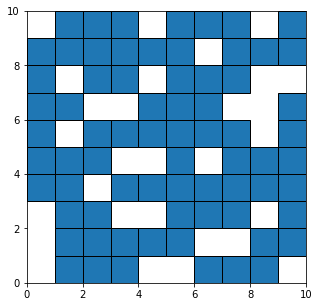

In [74]:
def random_mask(r, c, p):
    return np.random.random(size=(r,c)) > p

def draw_rectangle(lx, ly, widthx, widthy, **kws):
    pylab.gca().add_patch(patches.Rectangle((lx, ly), widthx, widthy,
                                           **kws))

def display_tiling_problem(mask):
    r, c = mask.shape
    for i in range(r):
        for j in range(c):
            if mask[i][j]:
                draw_rectangle(i, j, 1, 1, lw=1, ec='black')
    pylab.xlim(0, r)
    pylab.ylim(0, c)
                
m = random_mask(10, 10, 0.3)
pylab.figure(figsize=(5,5))
display_tiling_problem(m)
    

In [132]:
def matching_graph_for_tiling_mask(mask):
    r, c = mask.shape
    G = nx.DiGraph()
    G.add_nodes_from((a,b) for a in range(r) for b in range(c)
                     if mask[a][b])
    G.add_nodes_from(['s', 't'])
    adjacencies = [(0, 1), (0, -1), (-1, 0), (1, 0)]
    for u in G.nodes:
        if u in ['s', 't']:
            continue
        i, j = u
        if (i + j) % 2 == 0:
            G.add_edge(u, 't', c=1)
        else:
            G.add_edge('s', u, c=1)
            for dx, dy in adjacencies:
                v = (i + dx, j + dy)
                if v in G.nodes:
                    G.add_edge(u, v, c=1)
    return G

G = matching_graph_for_tiling_mask(m)
            

In [133]:
f = max_flow(G, 's', 't')
total_flow = sum(f[e] for e in f if e[0] == 's')
print("Found solution with total flow", total_flow)
# This should work, and find positive flow

Found solution with total flow 35


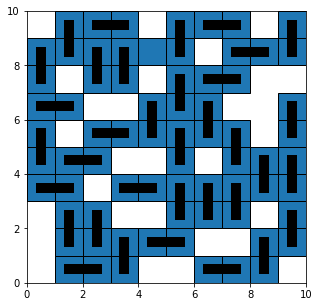

In [134]:
def display_tiling_solution(mask, pairs):
    display_tiling_problem(mask)
    for (u,v) in pairs:
        if u == 's' or v == 't':
            continue
        pylab.plot([u[0] + .5, v[0]+ .5], [u[1]+ .5, v[1]+ .5], 'k',
                  lw=10)
    
pylab.figure(figsize=(5,5))
display_tiling_solution(m, f.keys())
#This should display the associated tiling

Question 3
-----
OK.  Now, let's see how to get the same solution without implementing network flow, by formulating and solving the LP.

In [137]:
# print(G[(0,0)])
def max_flow_via_lp(G, s, t):
    # Your job: construct A, b, c.

    # Since our application only has unit capacity edges,
    # feel free to assume this (though it's easy enough to include
    # capacities.)
    # Try to keep your matrix size O(m) x O(m), not O(n^2) on either
    # axis.

    # Hint: one variable per edge.  You may also find it helpful
    # to read the documentation for scipy.optimize.linprog.
    m = len(G.edges)
    n = len(G.nodes)

    edge_to_index = {(u,v):i for i, (u,v) in enumerate(G.edges)}
    c = np.zeros(m)
    for v in G[s]:
        c[edge_to_index[(s,v)]] = 1

    # Now construct A_leq, b_leq, A_eq, b_eq
    A_leq = np.identity(m)        # m x m identity matrix
    b_leq = [1 for i in range(m)] # m x 1 matrix of all 1's
    A_eq = []                     # n x m matrix (1 = incoming edge, -1 = outgoing edge, 0 for all other nodes in row)
    b_eq = [0 for i in range(n)]  # n x 1 matrix of all 0's
    
    # Generate A_eq
    for node in G.nodes:
        if(node != 's' and node != 't'):
            temp = []
            for edge in G.edges:
                if(edge[0] == node):   # incoming edge
                    temp.append(1) 
                elif(edge[1] == node): # outgoing edge 
                    temp.append(-1)
                else:                  # edge not associated with current node 
                    temp.append(0)
        A_eq.append(temp)
    
    
    return scipy.optimize.linprog(-c, A_leq, b_leq, A_eq, b_eq)

lp_answer = max_flow_via_lp(G, 's', 't')
print("Got solution", -lp_answer.fun)
# Should be the same as the ford fulkerson result above.

Got solution 35.0


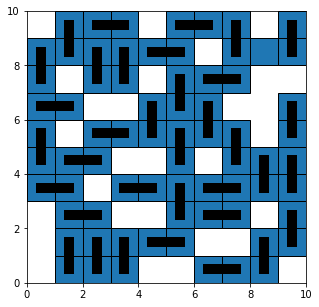

In [138]:
# Note: not certain this will be integer! One optimal solution with
# integer values exists, but not every LP solver will find it.
# The default solver---the simplex algorithm---should find it, though.


# Make sure this looks right!  If you chose a different mapping
# from edges to variables than edge_to_index, you may need to
# change things.

edge_indices_in_solution, = np.where(lp_answer.x == 1)
all_edges = list(G.edges)
edges_in_solution = [all_edges[i] for i in edge_indices_in_solution]
pylab.figure(figsize=(5,5))
display_tiling_solution(m, edges_in_solution)

